---
# Customer Profiling & Lifetime Value Visualization
---
## Authors
### Group 63
1. Debanjan Saha (saha.deb@northeastern.edu)
2. Ritika Rao (rao.rit@northeastern.edu)
- Affiliation: College of Engineering, Northeastern University, Boston
- Percentage of Contribution: 50-50

---
## Data Description
In this project, we use a retail store data to determine the customer lifetime value and predict the churn using the customer demographics data.
The dataset in available online in [Kaggle](https://www.kaggle.com/datasets/darpan25bajaj/retail-case-study-data)

The dataset comprises of three files:
- Customer: Customer information including demographics
- Transaction: Transaction of customers
- Product Hierarchy: Product information

A detailed description of the data dictionary is mentioned in our project report.

---
## Objective

We chose this dataset to handle the different prevalent scenarios that might considerably benefit holistic client profiling using Machine Learning in retail purchasing and marketing. In this project, we don't just develop one model with a specific goal in mind; instead, we look at numerous sorts of modeling and data mining techniques that can be performed using any transactional history dataset as well as customer demographic data. Customer demographics data is very sensitive for every organization because it contains a large amount of PII data. This is the only publically available dataset that provided us with all of the information we needed for our data mining problem. Our main goal was to make this project as much generalized as possible, and we aim to carry forward the learnings from this project into our future endeavors.


Using this data, we can perform various kinds of analysis such as:

- Time Series Analysis: Time series analysis can be performed on the transactions dataset to identify trends and patterns in customer purchases over time.

- Market Basket Analysis: Market basket analysis is a technique that analyzes customer transactions to determine which items are frequently purchased together. This can be visualized using association rule mining techniques such as Apriori algorithm. A network graph can be used to show the relationship between items.

## Recency-Frequency-Monetary (RFM) Analysis

## Customer Profiling

- Customer Segmentation: Based on the customer demographics, purchase history and behavior, the customers can be segmented into different groups. This can be visualized using clustering techniques such as K-Means.

- Customer Churn Analysis: Customer churn analysis can be performed to predict which customers are likely to leave the company. This can be visualized using decision tree algorithms and plotted on a bar chart to show the probability of customer churn.

- Customer Lifetime Value (CLV) Analysis: CLV is a prediction of the net profit attributed to the entire future relationship with a customer. This can be calculated by analyzing the customer's purchase history, behavior and demographics.

---

All these experiments are conducted as part of the coursework project for IE 7275 - Data Mining under Prof. Sagar Kamarthi

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Google Drive location where the data is stored
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7275 Project'

/content/drive/MyDrive/Northeastern/Projects/IE7275 Project


## Import Libraries

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import networkx as nx

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

## Project Timelines

In [5]:
# Create the data for gantt chart
df = [
        dict(Task="Initial Project Proposal", Start='2023-01-09', Finish='2023-01-27', Resource='01 - Problem Definition'),
        dict(Task="Final Project Proposal", Start='2023-01-27', Finish='2023-02-03', Resource='02 - Finalize Problem Definition'),
        dict(Task="Data Collection and EDA", Start='2023-02-03', Finish='2023-02-17', Resource='03 - Data Collection, Visualization, EDA'),
        dict(Task="Statistical Modeling", Start='2023-02-17', Finish='2023-03-03', Resource='04 - Trying models to finalize models'),
        dict(Task="Performance Evaluation", Start='2023-03-03', Finish='2023-03-17', Resource='05 - Evaluate model performance and improvements'),
        dict(Task="Draft Project Report", Start='2023-03-17', Finish='2023-03-24', Resource='06 - Drafting Project Report'),
        dict(Task="Presentation", Start='2023-03-24', Finish='2023-04-07', Resource='07 - Draft project slide deck'),
        dict(Task="Final Report", Start='2023-04-07', Finish='2023-04-14', Resource='08 - Final Report Submission'),
        dict(Task="Presentation Demo", Start='2023-04-07', Finish='2023-04-14', Resource='09 - Project Presentation Demo'),
      ]

# Create a gantt chart timeline
# Create the gantt chart with a slider to control the range of data
fig = px.timeline(df, x_start='Start', x_end='Finish', y='Resource', color='Task', 
                  title='Project Timeline', height=600)
# Update the layout to include the slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

# Show the gantt chart
fig.show()


## Data

In [6]:
# read all the data files from directory recursively
for file in list(glob('Data/*.csv')):
    filename = file.split('/')[1]
    # print(filename)
    if filename.split('.')[0] == 'Transactions':
        transactions = pd.read_csv(file)
    elif filename.split('.')[0] == 'Customer':
        customers = pd.read_csv(file)
    elif filename.split('.')[0] == 'prod_cat_info':
        prod_cat = pd.read_csv(file)
    else:
        print("Unknown File Found: ", file)

### Transactions Data

In [7]:
transactions.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [8]:
# Display data properties
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64
 8   total_amt         23053 non-null  float64
 9   Store_type        23053 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.8+ MB


In [9]:
# Descriptive Statistics on Transactions
transactions.describe(include='all')

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
count,2.305300e+04,23053.000000,23053,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053.000000,23053
unique,NaN,NaN,1129,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,13-07-2011,NaN,NaN,NaN,NaN,NaN,NaN,e-Shop
freq,NaN,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,9311
mean,5.007348e+10,271021.746497,NaN,6.149091,3.763632,2.432395,636.369713,248.667192,2107.308002,NaN
std,2.898194e+10,2431.692059,NaN,3.726372,1.677016,2.268406,622.363498,187.177773,2507.561264,NaN
min,3.268991e+06,266783.000000,NaN,1.000000,1.000000,-5.000000,-1499.000000,7.350000,-8270.925000,NaN
25%,2.493864e+10,268935.000000,NaN,3.000000,2.000000,1.000000,312.000000,98.280000,762.450000,NaN
50%,5.009313e+10,270980.000000,NaN,5.000000,4.000000,3.000000,710.000000,199.080000,1754.740000,NaN
75%,7.533000e+10,273114.000000,NaN,10.000000,5.000000,4.000000,1109.000000,365.715000,3569.150000,NaN


In [10]:
# Display number of null records
transactions.isnull().sum()

transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64

### Customer Demographics

In [11]:
customers.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB


In [13]:
customers.describe(include='all')

,customer_Id,DOB,Gender,city_code
count,5647.000000,5647,5645,5645.000000
unique,NaN,4056,2,NaN
top,NaN,27-12-1988,M,NaN
freq,NaN,7,2892,NaN
mean,271037.281034,NaN,NaN,5.472631
std,2451.261711,NaN,NaN,2.859918
min,266783.000000,NaN,NaN,1.000000
25%,268912.000000,NaN,NaN,3.000000
50%,271028.000000,NaN,NaN,5.000000
75%,273180.000000,NaN,NaN,8.000000


In [14]:
customers.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64

### Product Categoies

In [15]:
prod_cat.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [16]:
prod_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   prod_cat_code      23 non-null     int64 
 1   prod_cat           23 non-null     object
 2   prod_sub_cat_code  23 non-null     int64 
 3   prod_subcat        23 non-null     object
dtypes: int64(2), object(2)
memory usage: 864.0+ bytes


In [17]:
prod_cat.describe(include='all')

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
count,23.000000,23,23.000000,23
unique,NaN,6,NaN,18
top,NaN,Books,NaN,Mens
freq,NaN,6,NaN,3
mean,3.739130,NaN,6.130435,NaN
std,1.711389,NaN,3.805550,NaN
min,1.000000,NaN,1.000000,NaN
25%,2.500000,NaN,3.000000,NaN
50%,4.000000,NaN,5.000000,NaN
75%,5.000000,NaN,10.000000,NaN


In [18]:
prod_cat.isnull().sum()

prod_cat_code        0
prod_cat             0
prod_sub_cat_code    0
prod_subcat          0
dtype: int64

## EDA

### Transaction Feature Extraction

In [19]:
# Convert tran_date to datetime
transactions['tran_date'] = pd.to_datetime(transactions['tran_date'], infer_datetime_format=True)

# Extract month from tran_date
transactions['month'] = transactions['tran_date'].dt.month

# Extract week from tran_date
transactions['week'] = transactions['tran_date'].dt.isocalendar().week

#Extract week and day of week from tran_date
transactions['day_of_week'] = transactions['tran_date'].dt.dayofweek

# Display final dataframe
transactions.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,month,week,day_of_week
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,2,9,3
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,2,9,0
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,2,9,0
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,2,8,6


### Customer Feature Extraction

In [20]:
# We need to convert the Customers DOB column to datetime format
customers['DOB'] = pd.to_datetime(customers['DOB'])

# Calculate Age of customers based on their DOB
now = pd.to_datetime('now').year
customers['Age'] = now - customers['DOB'].dt.year

# Create age group
customers['Age_Group'] = pd.cut(customers['Age'], bins=[0, 18, 25, 35, 45, 55, 65, 75, 100], 
                                labels=['<18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '>75'])

# Display the final Dataframe
customers.head()

,customer_Id,DOB,Gender,city_code,Age,Age_Group
0,268408,1970-02-01,M,4.0,53,45-55
1,269696,1970-07-01,F,8.0,53,45-55
2,268159,1970-08-01,F,8.0,53,45-55
3,270181,1970-10-01,F,2.0,53,45-55
4,268073,1970-11-01,M,1.0,53,45-55


### Merge Transactions-Customers

In [21]:
# Merge transactions and customers on cust_id
trans_cust = pd.merge(transactions, customers, left_on='cust_id', right_on='customer_Id')
trans_cust.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,month,week,day_of_week,customer_Id,DOB,Gender,city_code,Age,Age_Group
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,270351,1981-09-26,M,5.0,42,35-45
1,80712190438,270351,2014-02-20,1,1,5,772,405.300,4265.300,e-Shop,2,8,3,270351,1981-09-26,M,5.0,42,35-45
2,36957441426,270351,2013-09-16,3,2,3,361,113.715,1196.715,Flagship store,9,38,0,270351,1981-09-26,M,5.0,42,35-45
3,12236277258,270351,2013-03-18,8,3,3,1030,324.450,3414.450,e-Shop,3,12,0,270351,1981-09-26,M,5.0,42,35-45
4,13181563739,270351,2011-12-13,6,5,1,1048,110.040,1158.040,e-Shop,12,50,1,270351,1981-09-26,M,5.0,42,35-45


### Merge Transactions-ProductCategories

In [22]:
# Merge the transactions and prod_cat datasets on prod_cat_code
trans_prod = transactions.merge(prod_cat, on='prod_cat_code')
trans_prod.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,month,week,day_of_week,prod_cat,prod_sub_cat_code,prod_subcat
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.30,-4265.30,e-Shop,2,9,4,Clothing,4,Mens
1,80712190438,270351,2014-02-28,1,1,-5,-772,405.30,-4265.30,e-Shop,2,9,4,Clothing,1,Women
2,80712190438,270351,2014-02-28,1,1,-5,-772,405.30,-4265.30,e-Shop,2,9,4,Clothing,3,Kids
3,79792372943,275108,2014-02-22,3,1,-3,-908,286.02,-3010.02,MBR,2,8,5,Clothing,4,Mens
4,79792372943,275108,2014-02-22,3,1,-3,-908,286.02,-3010.02,MBR,2,8,5,Clothing,1,Women


## Data Visualizations

### Statistical Plots

#### Relationship between numerical features

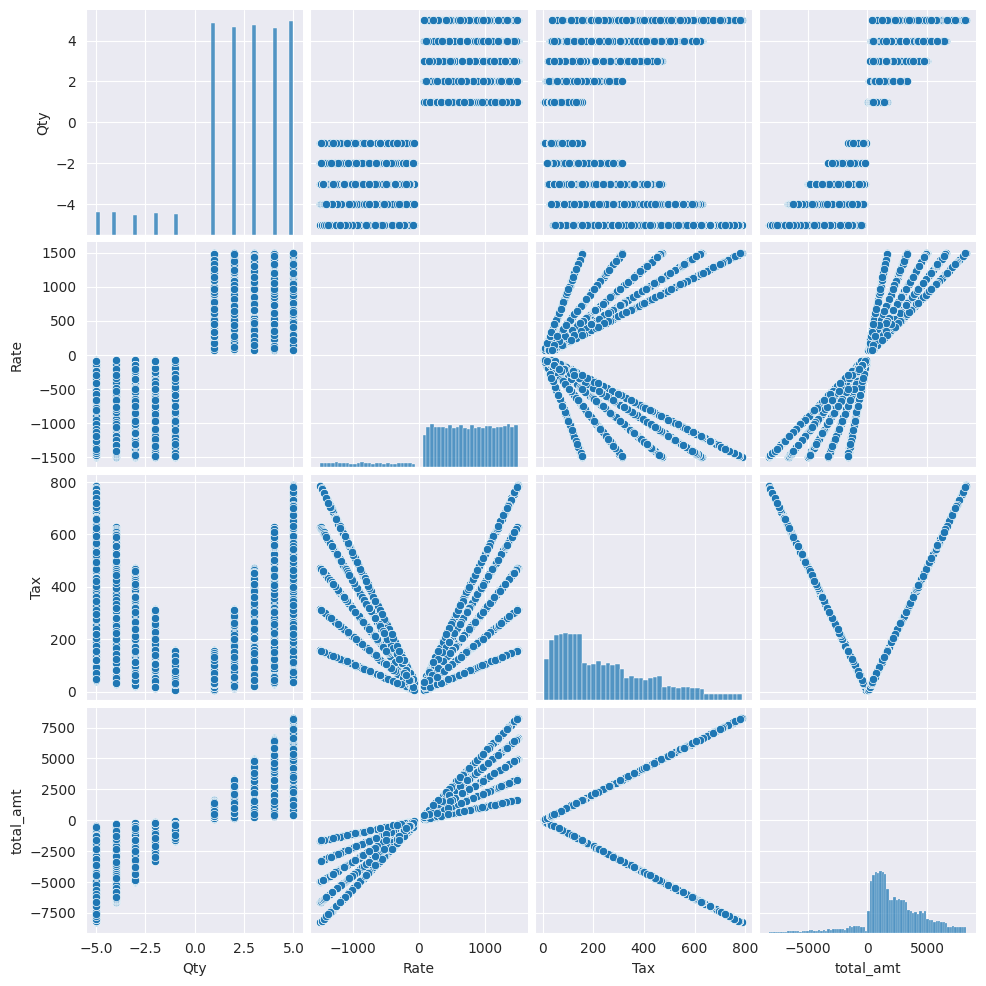

In [23]:
# Create a pairplot
sns.pairplot(transactions[['Qty', 'Rate', 'Tax', 'total_amt']])
plt.show()

#### Correlation Heatmap

<Axes: >

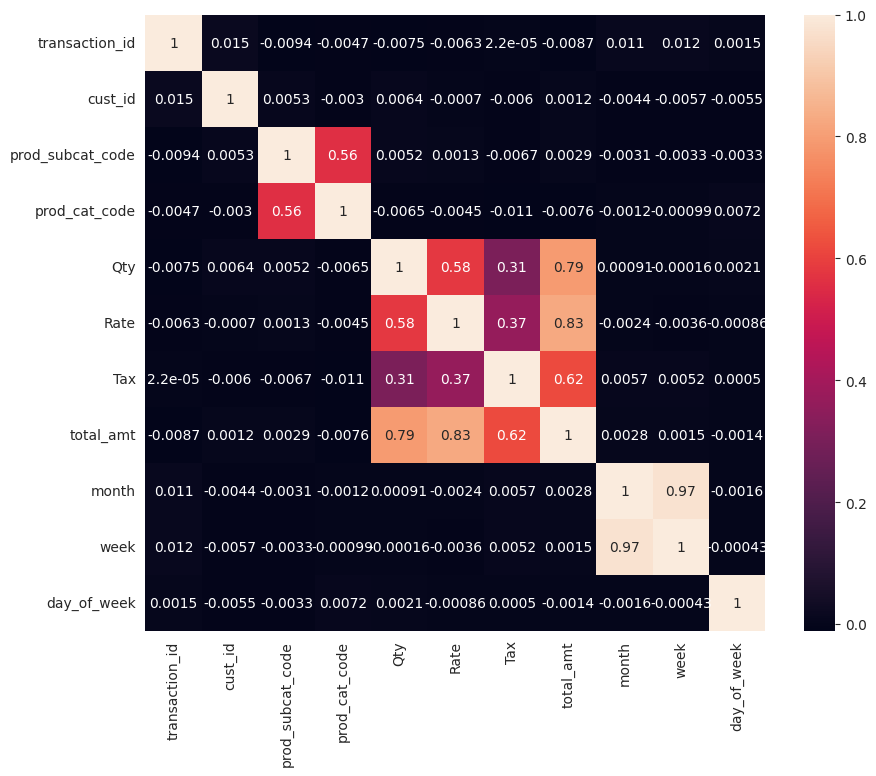

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(transactions.corr(), annot=True)

### Total Spendings Distribution 

In [25]:
# Create a histogram
fig = px.histogram(transactions, x='total_amt', nbins=100,
                   title='Distribution of Total Amount Spent')
fig.show()

#### Total spendings by customers who have spent atleast 20k USD

In [26]:
# Group by customer_id and sum the total_amt 
df_grouped = transactions.groupby('cust_id')['total_amt'].sum().reset_index()
transactions_20k = df_grouped[df_grouped['total_amt'] > 20000]

# Plot the histogram
fig = px.histogram(transactions_20k, x='total_amt', nbins=100,
                   title='Distribution of Total Spending over 20k USD by Customers')
fig.show()


### Transaction Volume Analysis

#### Total and Average Transaction Volume Analysis by Month of Year



In [27]:
#Group transactions by month and calculate sum and mean of total_amt
tran_vol = transactions.groupby('month')['total_amt'].agg(['sum', 'mean']).reset_index()

#Plot total transaction volume by months
fig1 = px.line(tran_vol, x='month', y='sum')
fig1.update_layout(title='Total Transaction Volume by Months', 
                   xaxis_title='Month', yaxis_title='Total Transaction Volume')
fig1.show()

#Plot average transaction volume by months
fig2 = px.line(tran_vol, x='month', y='mean')
fig2.update_layout(title='Average Transaction Volume by Months', 
                   xaxis_title='Month', yaxis_title='Average Transaction Volume')
fig2.show()


#### Total and Average Transaction Volume Analysis by Week

In [28]:
#Group transactions by week and day of week and calculate sum and mean of total_amt
tran_vol = transactions.groupby(['week'])['total_amt'].agg(['sum', 'mean']).reset_index()

#Plot total transaction volume by week
fig1 = px.line(tran_vol, x='week', y='sum')
fig1.update_layout(title='Total Transaction Volume by Week', 
                   xaxis_title='Week', yaxis_title='Total Transaction Volume by Week')
fig1.show()

#Plot average transaction volume by week
fig2 = px.line(tran_vol, x='week', y='mean')
fig2.update_layout(title='Average Transaction Volume by Week', 
                   xaxis_title='Week', yaxis_title='Average Transaction Volume by Week')
fig2.show()


#### Total and Average Transaction Volume Analysis by Day of Week

In [29]:
#Group transactions by week and day of week and calculate sum and mean of total_amt
tran_vol = transactions.groupby(['day_of_week'])['total_amt'].agg(['sum', 'mean']).reset_index()

#Plot total transaction volume by day of week
fig1 = px.line(tran_vol, x='day_of_week', y='sum')
fig1.update_layout(title='Total Transaction Volume by Day of Week', 
                   xaxis_title='Day of Week', yaxis_title='Total Transaction Volume by Day of Week')
fig1.show()

#Plot average transaction volume by week
fig2 = px.line(tran_vol, x='day_of_week', y='mean')
fig2.update_layout(title='Average Transaction Volume by Day of Week', 
                   xaxis_title='Day of Week', yaxis_title='Average Transaction Volume by Day of Week')
fig2.show()


### Transaction Quantity Analysis

#### Total and Average Transaction Quantity by Months

In [30]:
# Group transactions by month and calculate sum and mean of total_amt
tran_qty = transactions.groupby('month')['Qty'].agg(['sum', 'mean']).reset_index()

# Plot total transaction quantity by months using plotly
fig = px.line(tran_qty, x='month', y='sum')
fig.update_layout(title='Total Transaction Quantity by Months', xaxis_title='Month', yaxis_title='Total Transaction Quantity')
fig.show()

# Plot average transaction quantity by months using plotly
fig = px.line(tran_qty, x='month', y='mean')
fig.update_layout(title='Average Transaction Quantity by Months', xaxis_title='Month', yaxis_title='Average Transaction Quantity')
fig.show()

#### Average Transaction Quantity by Customers Gender

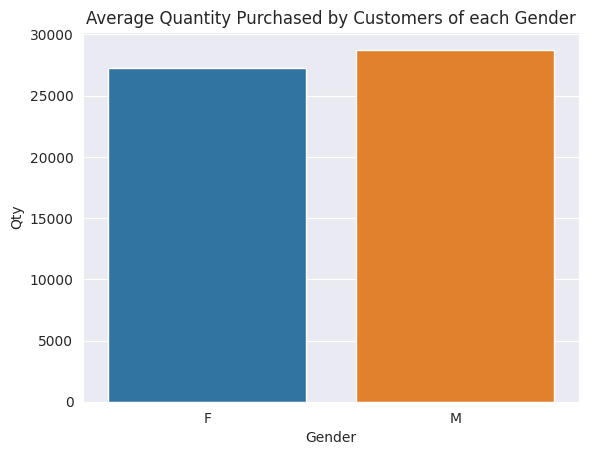

In [31]:
# Group by Gender and sum the Qty
trans_cust_grouped = trans_cust.groupby('Gender')['Qty'].sum().reset_index()

# Create a barplot
sns.barplot(x='Gender', y='Qty', data=trans_cust_grouped, ci='sd')
plt.title('Average Quantity Purchased by Customers of each Gender')
plt.show()

#### Quantity Purchased by the rate of the Product

In [32]:
# Create a scatter plot
fig = px.scatter(transactions, x='Rate', y='Qty', color='prod_cat_code',
                 title='Relationship between Quantity Purchased and Rate of each Product')
fig.show()

### Customer Spending Patterns

#### Average customer spending patterns by Gender

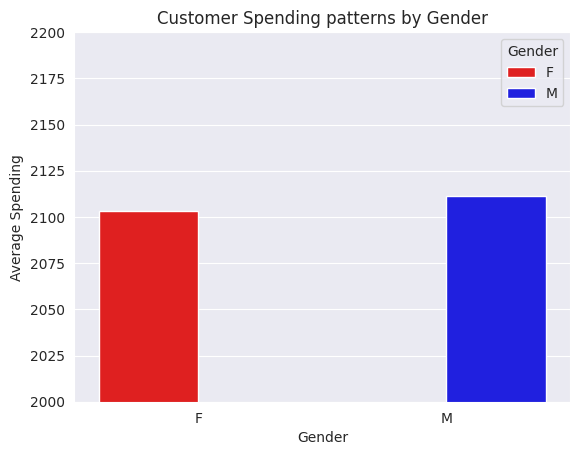

In [33]:
# Group the data by Gender and calculate average spending of each group
gender_spending = trans_cust.groupby(['Gender'])['total_amt'].mean().reset_index()

sns.barplot(x='Gender', y='total_amt', data=gender_spending, hue='Gender', palette=['red','blue'])
plt.xlabel('Gender')
plt.ylabel('Average Spending')
plt.title('Customer Spending patterns by Gender')
plt.ylim(2000,2200)
plt.show()

#### Total customer spendings by product categories

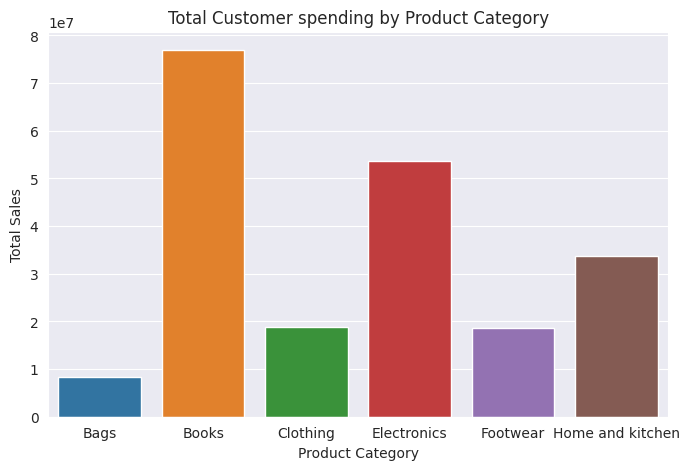

In [34]:
# Group by prod_cat and sum the total_amt
trans_prod_grouped = trans_prod.groupby('prod_cat')['total_amt'].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='prod_cat', y='total_amt', data=trans_prod_grouped)
plt.title('Total Customer spending by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.show()

#### Customer Spending by Age Group

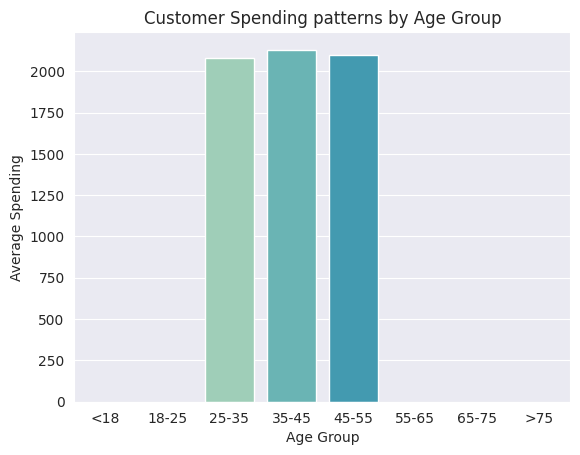

In [35]:
# Group the data by Age_Group and calculate average spending of each group
age_group_spending = trans_cust.groupby(['Age_Group'])['total_amt'].mean().reset_index()

# Plot the average spending of each age group
sns.barplot(x='Age_Group', y='total_amt', data=age_group_spending, palette='YlGnBu')
plt.xlabel('Age Group')
plt.ylabel('Average Spending')
plt.title('Customer Spending patterns by Age Group')
plt.show()

#### Customer spending patterns by City

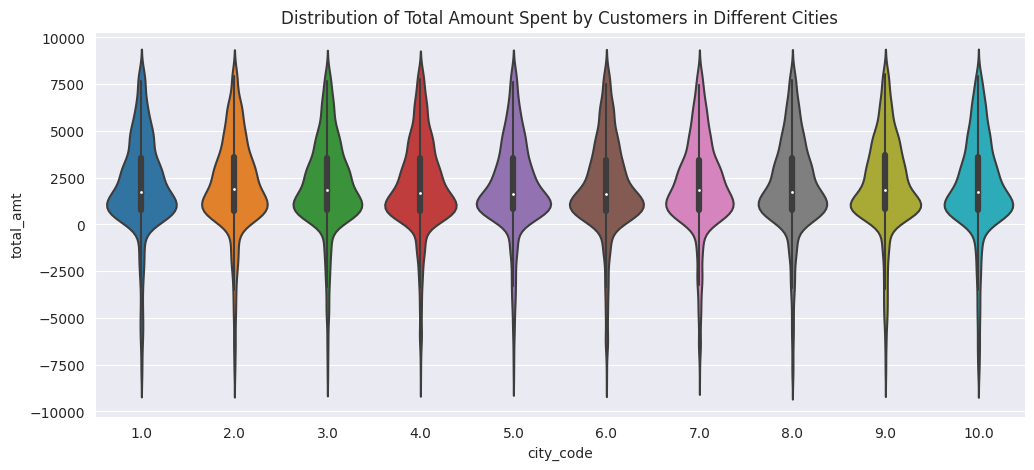

In [36]:
# Create a violin plot
plt.figure(figsize=(12,5))
sns.violinplot(x='city_code', y='total_amt', data=trans_cust)
plt.title('Distribution of Total Amount Spent by Customers in Different Cities')
plt.show()

### Sales Trends

#### Total Sales trends by date

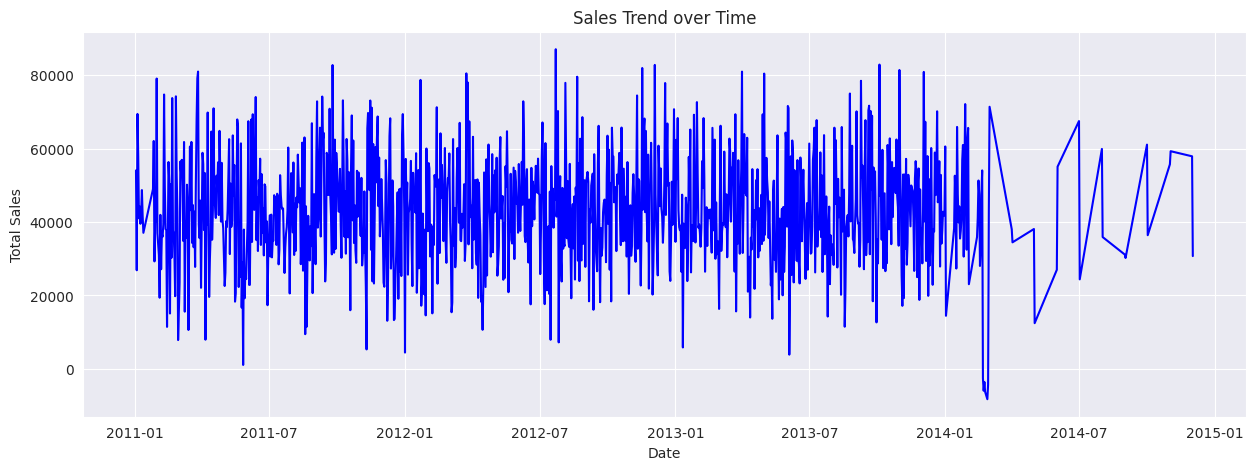

In [37]:
# Group the data by date and calculate total sales for each date
sales_trend = transactions.groupby(['tran_date'])['total_amt'].sum().reset_index()

# Plot the total sales over time
plt.figure(figsize=(15,5))
plt.plot(sales_trend['tran_date'], sales_trend['total_amt'], color='blue')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Trend over Time')
plt.show()

#### Sales trends per weeks for the year of 2012

In [38]:
# Group the data by week and calculate total sales for each week
data_2012 = transactions[transactions['tran_date'].dt.year == 2012]
sales_trend = data_2012.groupby([data_2012['tran_date'].dt.isocalendar().week])['total_amt'].sum().reset_index()

# Plot the total sales by week
plt.figure(figsize=(12,5))
fig = px.bar(sales_trend, x='week', y='total_amt', color='total_amt', 
             color_continuous_scale='teal', title='Sales Trend by Week')
fig.update_layout(xaxis_title="Week", yaxis_title="Total Sales")
fig.show()


<Figure size 1200x500 with 0 Axes>

#### Sales trends by product categories

In [39]:
# Group the data by product category and calculate the total sales for each category
cat_sales = transactions.groupby(['prod_cat_code'])['total_amt'].sum().reset_index()

# Plot the total sales by product category
fig = px.bar(cat_sales, x='prod_cat_code', y='total_amt', color='total_amt',
             color_continuous_scale='teal',
             title='Product Category Sales Trend')
fig.show()


#### Sales trends in Product Category by Gender and Store types

In [40]:
# Get unique product categories
prod_cat_codes = trans_cust['prod_cat_code'].unique()

# Get the sales data for each product category, gender and store type
sales_data = trans_cust.groupby(['prod_cat_code', 'Gender', 'Store_type'])['total_amt'].sum().reset_index(name='sales')

# Create the treemap
fig = px.treemap(sales_data, path=['prod_cat_code', 'Gender', 'Store_type'], values='sales',
                 title='Product Category Sales Trend Analysis by Gender and Store Type',
                 color_continuous_scale='Inferno')
fig.show()

---
## Customer Segmentation
---

### Customer Segmentation based on Age, Gender, and City

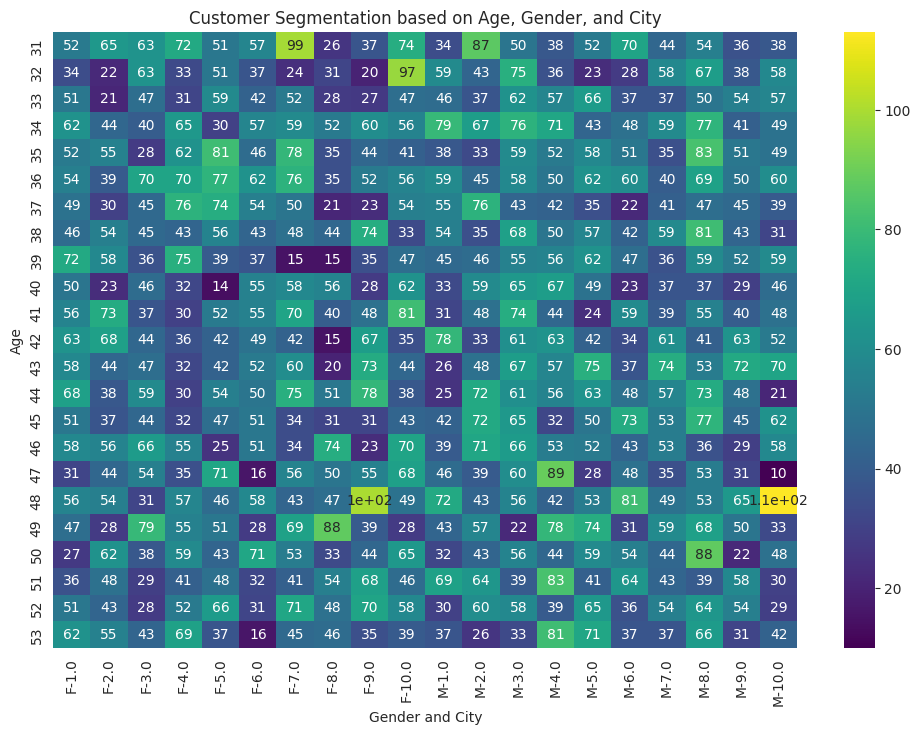

In [41]:
# Create a pivot table with age, gender and city as columns, and customer_id as values
customer_segment = pd.pivot_table(trans_cust, values='customer_Id', index=['Age'], 
                                  columns=['Gender', 'city_code'], aggfunc='count')

# Plot a heatmap to visualize the customer segmentation
plt.figure(figsize=(12,8))
sns.heatmap(customer_segment, cmap='viridis', annot=True)
plt.xlabel('Gender and City')
plt.ylabel('Age')
plt.title('Customer Segmentation based on Age, Gender, and City')
plt.show()

### Customer Segmentation based on Total Purchase Amount

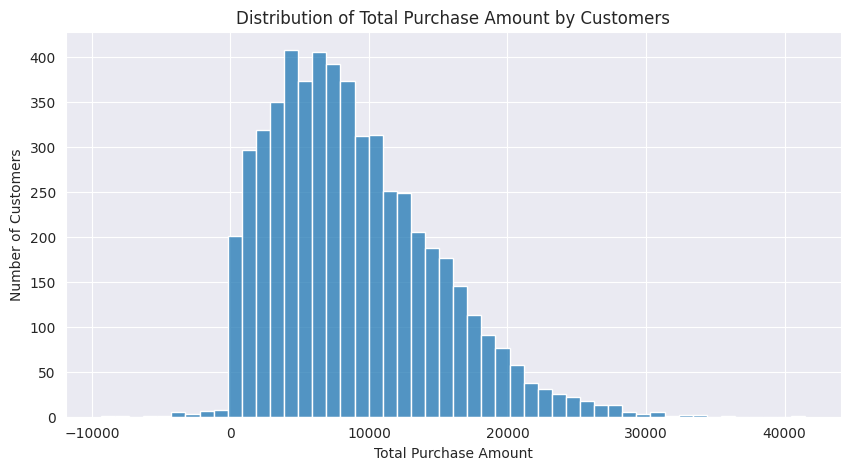

In [42]:
# Calculate total purchase amount by each customer
cust_purch_amt = trans_cust.groupby('cust_id')['total_amt'].sum().reset_index()

# Plot the distribution of total purchase amount by customers
plt.figure(figsize=(10,5))
sns.histplot(cust_purch_amt['total_amt'], kde=False, bins=50)
plt.xlabel('Total Purchase Amount')
plt.ylabel('Number of Customers')
plt.title('Distribution of Total Purchase Amount by Customers');

In [43]:
# Perform KMeans clustering to segment customers
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cust_purch_amt[['total_amt']])
cust_purch_amt['segment'] = kmeans.predict(cust_purch_amt[['total_amt']])

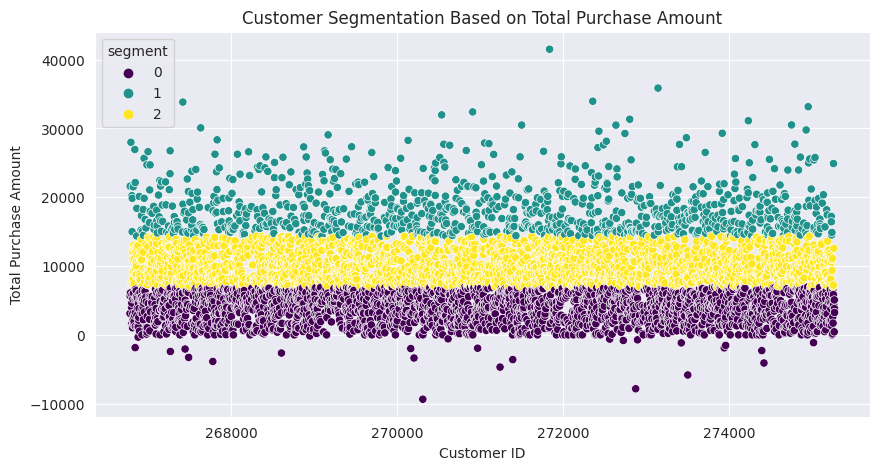

In [44]:
# Plot the segments of customers based on their total purchase amount
plt.figure(figsize=(10,5))
sns.scatterplot(x='cust_id', y='total_amt', hue='segment', 
                data=cust_purch_amt, palette = 'viridis')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchase Amount')
plt.title('Customer Segmentation Based on Total Purchase Amount');

### Time Series Segmentation of the data

In [45]:
# Group the transactions data by customer id and tran_date
transactions_grouped = transactions.groupby(['cust_id', 'tran_date'])['total_amt'].sum().reset_index()

# Pivot the data to create a time series
transactions_pivot = transactions_grouped.pivot(index='tran_date', columns='cust_id', values='total_amt')

# Fill the missing values with 0
transactions_pivot.fillna(0, inplace=True)

# Transpose the data
transactions_pivot_transposed = transactions_pivot.T

In [46]:
# Create a list of customers 
customers_list = transactions_pivot_transposed.index.tolist()

# Normalize the data
scaler = MinMaxScaler()
transactions_pivot_transposed_scaled = scaler.fit_transform(transactions_pivot_transposed)


In [47]:
# Fit the K-means model
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(transactions_pivot_transposed_scaled)

KMeans(n_clusters=3, random_state=0)

In [48]:
# Get the cluster labels
labels = kmeans.labels_

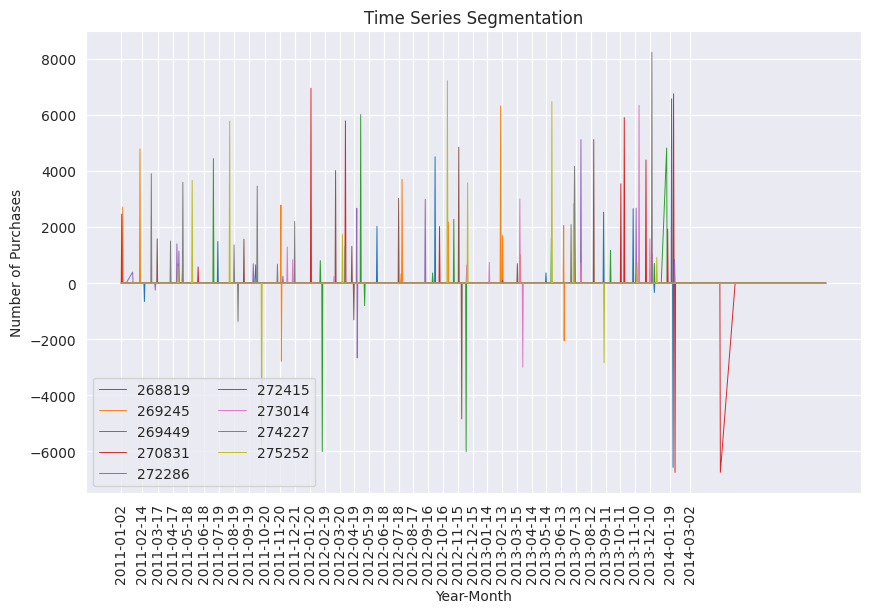

In [49]:
# Set the start and end dates as the minimum and maximum dates across all customers
start_date = transactions_pivot_transposed.columns.min()
end_date = transactions_pivot_transposed.columns.max()

# Filter out the customers who have purchased at least 12 times
filtered_customers = transactions_pivot_transposed.loc[(transactions_pivot_transposed!=0).sum(axis=1) >= 12].index

# Plot the time series for each customer
plt.figure(figsize=(10,6))
for i in range(len(filtered_customers)):
    customer_time_series = transactions_pivot_transposed.loc[filtered_customers[i], start_date:end_date]
    plt.plot(customer_time_series.index, customer_time_series, label=filtered_customers[i], linewidth=0.7)

# Add the cluster labels to the plot
plt.legend(loc='best', ncol=2)
plt.xlabel('Year-Month')
plt.ylabel('Number of Purchases')
plt.title('Time Series Segmentation')
plt.xticks(customer_time_series.index[::30],  rotation='vertical')
# plt.margins(0.2)
plt.show()


---
## Market Basket Analysis
---

In [50]:
# Decode the product codes into product names
transactions_str = transactions.copy()
transactions_str = transactions_str.merge(prod_cat[['prod_cat_code', 'prod_cat']], on='prod_cat_code')
transactions_str = transactions_str.merge(prod_cat[['prod_sub_cat_code', 'prod_subcat']], left_on='prod_subcat_code', right_on='prod_sub_cat_code')
transactions_str

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,month,week,day_of_week,prod_cat,prod_sub_cat_code,prod_subcat
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,Clothing,1,Women
1,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,Clothing,1,Mens
2,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,Clothing,1,Mens
3,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,Clothing,1,Women
4,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,2,9,4,Clothing,1,Mens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229005,39737254095,272286,2011-01-25,2,6,5,71,37.275,392.275,e-Shop,1,4,1,Home and kitchen,2,Furnishing
229006,85115299378,271020,2011-01-25,2,6,4,1052,441.840,4649.840,MBR,1,4,1,Home and kitchen,2,Furnishing
229007,85115299378,271020,2011-01-25,2,6,4,1052,441.840,4649.840,MBR,1,4,1,Home and kitchen,2,Furnishing
229008,85115299378,271020,2011-01-25,2,6,4,1052,441.840,4649.840,MBR,1,4,1,Home and kitchen,2,Furnishing


In [51]:
# Create a pivot table with customer_id as index and items as columns
transactions_pivot = transactions_str.pivot_table(index='cust_id', columns='prod_cat', values='Qty', aggfunc='sum')
transactions_pivot.fillna(0, inplace=True)
transactions_pivot.head()

prod_cat,Bags,Books,Clothing,Electronics,Footwear,Home and kitchen
cust_id,,,,,,
266783,0.0,36.0,48.0,0.0,0.0,0.0
266784,0.0,84.0,0.0,40.0,0.0,0.0
266785,18.0,60.0,0.0,0.0,156.0,0.0
266788,12.0,6.0,0.0,0.0,57.0,0.0
266794,36.0,84.0,63.0,50.0,45.0,0.0


In [52]:
# Create a basket dataset with items as product names
basket = transactions_str.groupby(['cust_id', 'prod_cat'])['Qty'].sum().unstack().reset_index().fillna(0).set_index('cust_id')
basket = basket.applymap(lambda x: 1 if x>0 else 0)
basket.head()

prod_cat,Bags,Books,Clothing,Electronics,Footwear,Home and kitchen
cust_id,,,,,,
266783,0,1,1,0,0,0
266784,0,1,0,1,0,0
266785,1,1,0,0,1,0
266788,1,1,0,0,1,0
266794,1,1,1,1,1,0


### Association Rules

In [53]:
# Get frequent itemsets with a minimum support of 0.01
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
frequent_itemsets

# Get association rules with a minimum confidence of 0.6
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bags),(Books),0.251907,0.589720,0.142753,0.566691,0.960948,-0.005801,0.946852
1,(Bags),(Electronics),0.251907,0.528696,0.128769,0.511175,0.966860,-0.004414,0.964157
2,(Clothing),(Books),0.353433,0.589720,0.204504,0.578623,0.981182,-0.003922,0.973664
3,(Electronics),(Books),0.528696,0.589720,0.301126,0.569564,0.965820,-0.010657,0.953172
4,(Books),(Electronics),0.589720,0.528696,0.301126,0.510625,0.965820,-0.010657,0.963074
5,(Footwear),(Books),0.357065,0.589720,0.205412,0.575280,0.975513,-0.005156,0.966000
6,(Home and kitchen),(Books),0.459499,0.589720,0.263712,0.573913,0.973195,-0.007263,0.962901
7,(Clothing),(Electronics),0.353433,0.528696,0.179077,0.506680,0.958359,-0.007781,0.955373
8,(Footwear),(Electronics),0.357065,0.528696,0.179077,0.501526,0.948609,-0.009701,0.945494
9,(Home and kitchen),(Electronics),0.459499,0.528696,0.236469,0.514625,0.973385,-0.006466,0.971009


In [54]:
# Sorting the rules by lift
rules.sort_values(by='lift', ascending=False, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,"(Clothing, Bags)",(Books),0.087541,0.589720,0.052307,0.597510,1.013210,0.000682,1.019355
25,"(Clothing, Bags, Footwear)",(Books),0.029059,0.589720,0.017254,0.593750,1.006833,0.000117,1.009919
24,"(Clothing, Bags, Electronics)",(Books),0.042317,0.589720,0.024882,0.587983,0.997054,-0.000074,0.995783
16,"(Bags, Home and kitchen)",(Electronics),0.110243,0.528696,0.057210,0.518946,0.981558,-0.001075,0.979731
2,(Clothing),(Books),0.353433,0.589720,0.204504,0.578623,0.981182,-0.003922,0.973664
5,(Footwear),(Books),0.357065,0.589720,0.205412,0.575280,0.975513,-0.005156,0.966000
22,"(Books, Home and kitchen)",(Electronics),0.263712,0.528696,0.135852,0.515152,0.974381,-0.003572,0.972065
21,"(Electronics, Home and kitchen)",(Books),0.236469,0.589720,0.135852,0.574501,0.974192,-0.003599,0.964231
29,"(Bags, Books, Home and kitchen)",(Electronics),0.061751,0.528696,0.031784,0.514706,0.973539,-0.000864,0.971172
9,(Home and kitchen),(Electronics),0.459499,0.528696,0.236469,0.514625,0.973385,-0.006466,0.971009


### Network Graph

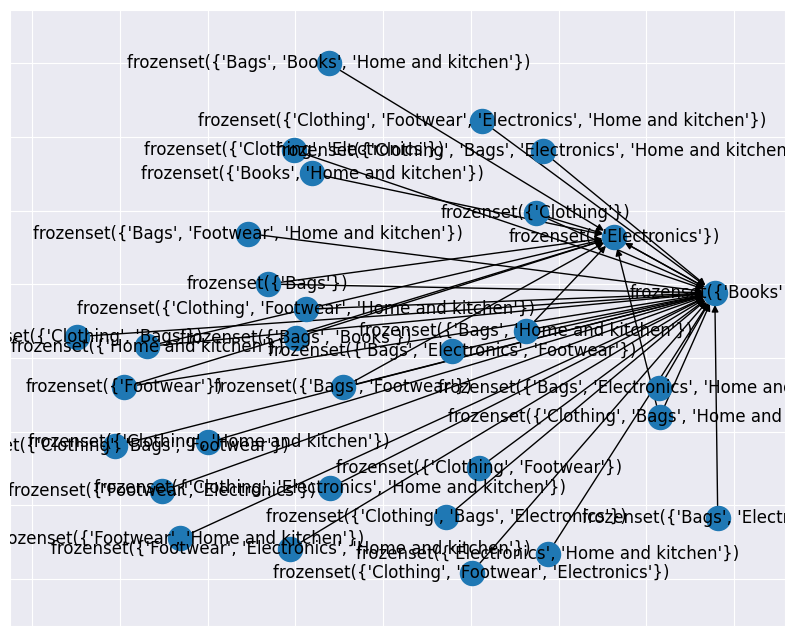

In [55]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for antecedent in rules['antecedents'].unique():
    G.add_node(antecedent)
for consequent in rules['consequents'].unique():
    G.add_node(consequent)
    
# Add edges to the graph
for i, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'])

plt.figure(figsize=(10,8))
# Plot the graph using product names
nx.draw_networkx(G, with_labels=True, labels={node: node for node in G.nodes()})
plt.show()